Boilerplate Connection Setup
---

In [14]:
%vertica SELECT 'Connected'

,?column?
0,Connected


In [15]:
experiment_id = 8416329705

In [16]:
import datetime
from dateutil.tz import tzutc

experiment_start = datetime.datetime(2017, 6, 13, 0, tzinfo=tzutc())

In [17]:
%%vertica

SET TIME ZONE 'UTC'

In [18]:
%%vertica (experiment_start, experiment_id) -> df

-- This query should return a single row per enrollment per week.
SELECT
    viewed.user_id,
    viewed.course_id,
    viewed.variation_name,
    week_num.weeks_since_experiment_start,
    course.pacing_type,
    COALESCE(engaged.engagement_events, 0) AS engagement_events,
    CASE WHEN COALESCE(engaged.engagement_events, 0) > 0 THEN 1 ELSE 0 END AS is_engaged
FROM
(
    -- Returns one row per enrollment (user_id, course_id). Excludes enrollments that were exposed to multiple
    -- variants of the experiment.
    
    SELECT
        user_id,
        course_id,
        MIN(variation_name) AS variation_name,
        MIN(received_at) AS exposure_time
    FROM
        ret.experiment_views
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT variation_name) = 1
) AS viewed

JOIN
(
    -- This table simply returns one row with one integer for each week after the start of the experiment that
    -- represents the number of weeks that have elapsed since the start of the experiment. This will look something
    -- like:
    --    weeks_since_experiment_start
    --    0
    --    1
    --    2
    SELECT DISTINCT
        FLOOR(DATEDIFF('day', :experiment_start, date) / 7) AS weeks_since_experiment_start
    FROM business_intelligence.calendar
    WHERE
        date BETWEEN :experiment_start AND (
            SELECT MAX(date) FROM business_intelligence.activity_engagement_user_daily
        )
    ORDER BY 1 ASC

-- This join condition will ensure that we get one full copy of our enrollments per week. The first copy will
-- have week_num.weeks_since_experiment_start == 0, the second 1, the third 2 etc.
) AS week_num ON 1=1

-- To get the pacing type for the course
JOIN production.d_course AS course ON viewed.course_id = course.course_id


-- Gather engagement data for each enrollment. This will only return rows for enrollments that were engaged in
-- the course.
LEFT JOIN
(
    SELECT
        user_id,
        engage.course_id,
        FLOOR(DATEDIFF('day', :experiment_start, date) / 7) AS weeks_since_experiment_start,
        SUM(cnt_engaged_activity) AS engagement_events
    FROM
        business_intelligence.activity_engagement_user_daily AS engage
    WHERE
        date > :experiment_start
    GROUP BY 1, 2, 3
) AS engaged
ON      engaged.user_id = viewed.user_id
    AND engaged.course_id = viewed.course_id
    AND engaged.weeks_since_experiment_start = week_num.weeks_since_experiment_start


In [19]:
%%vertica (experiment_start) -> max_week_num_df
SELECT
    FLOOR(DATEDIFF('day', :experiment_start, MAX(date)) / 7)
FROM
    business_intelligence.activity_engagement_user_daily

In [20]:
# Get the max week number and add one since it's zero indexed
num_records_per_enrollment = max_week_num_df.FLOOR[0] + 1
num_records_per_enrollment

Decimal('6')

In [21]:
a = df.groupby(['user_id', 'course_id']).size()
assert len(a[a != num_records_per_enrollment]) == 0, 'There should be exactly one record per enrollment per week'

In [22]:
import edx_stats
import edx_plot
from plotnine import *

In [23]:
conf_intervals = edx_stats.grouped_confidence_intervals(
    df,
    variant_col='variation_name',
    value_col='is_engaged',
    ctrl_name='Original',
    group_cols=['pacing_type', 'weeks_since_experiment_start'],
)

/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


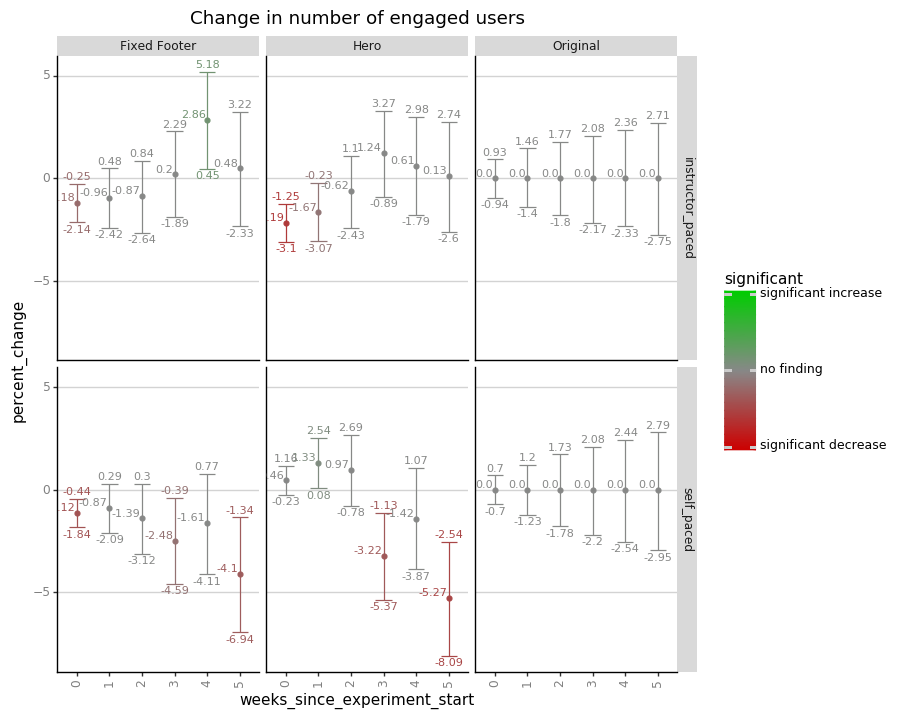

<ggplot: (8773203539902)>

In [24]:
(
    ggplot(conf_intervals.reset_index(), aes(
        x='weeks_since_experiment_start',
        y='percent_change',
        ymin='lower_bound',
        ymax='upper_bound',
        color='significant',
        label_size=0.5,
    ))
    + edx_plot.geom_confidence()
    + facet_grid("pacing_type ~ variation_name")
    + edx_plot.theme_confidence()
    + ggtitle("Change in number of engaged users")
)


In [25]:
conf_intervals = edx_stats.grouped_confidence_intervals(
    df,
    variant_col='variation_name',
    value_col='engagement_events',
    ctrl_name='Original',
    group_cols=['pacing_type', 'weeks_since_experiment_start'],
)

/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


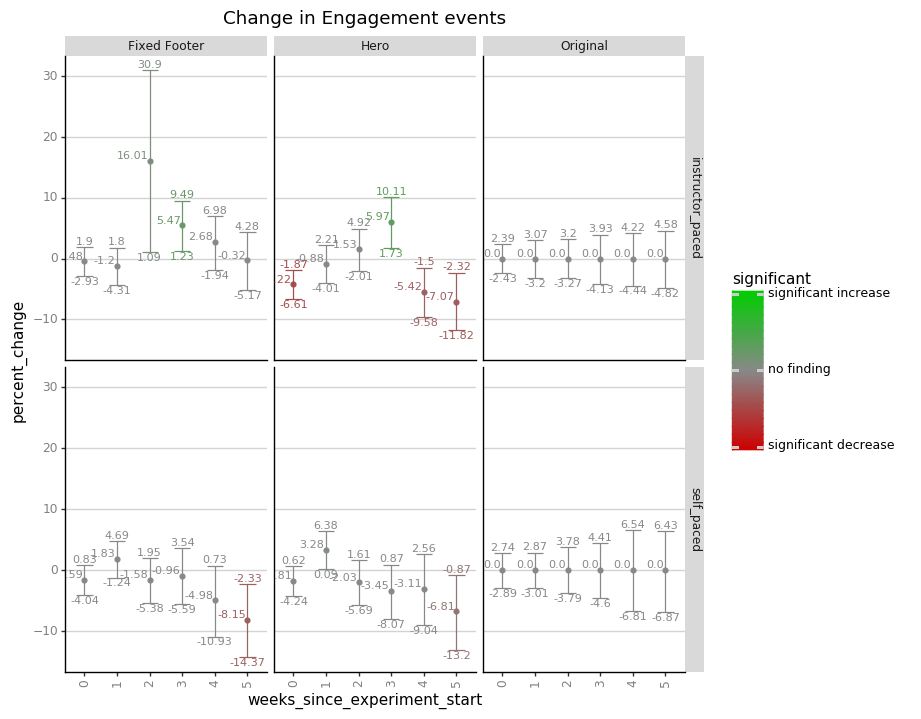

<ggplot: (8773188543990)>

In [26]:
(
    ggplot(conf_intervals.reset_index(), aes(
        x='weeks_since_experiment_start',
        y='percent_change',
        ymin='lower_bound',
        ymax='upper_bound',
        color='significant',
        label_size=0.5,
    ))
    + edx_plot.geom_confidence()
    + facet_grid("pacing_type ~ variation_name")
    + edx_plot.theme_confidence()
    + ggtitle("Change in Engagement events")
)
